In [1]:
library(dplyr)
library(survival)
library(survminer)
library(gtsummary)
library(stringr)
library(lubridate)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
# 1. Load Data
raw_data <- read.csv("data/data.csv")

In [3]:
# 2. Clean Data (Standard Routine)
analysis_data <- raw_data %>%
  mutate(
    # --- Dates & Status ---
    Date_Diagnosis = ymd(Fecha_diag),
    Date_LastContact = ymd(Fecha_ultcont),
    Date_Death = ymd(Fecha_fall),
    Age = as.numeric(Anio_diag) - as.numeric(Anio_nac),
    OS_status = case_when(
      toupper(Estado_vital) %in% c("FALLECIDO", "MUERTO", "DEAD") ~ 1,
      TRUE ~ 0
    ),
    End_Date = if_else(OS_status == 1, Date_Death, Date_LastContact),
    OS_time = as.numeric(difftime(End_Date, Date_Diagnosis, units = "days")) / 30.4375,

    # --- Sex ---
    Sex = factor(Sexo, levels = c("Mujer", "Hombre"), labels = c("Female", "Male")),

    # --- Survivorship Variable ---
    # 0 Prior = "Primary Lymphoma Only"
    # 1+ Prior = "Multiple Primary Cancers"
    Survivorship_Group = if_else(Num_tumores == 0, "Primary Lymphoma Only", "Multiple Primary Cancers"),

    # --- Geographic Grouping (Micro-Level) ---
    Parish_Raw = toupper(Parr_res),
    Socioeconomic_Zone = case_when(
      # The "Urban Core" (Default)
      Parish_Raw == "QUITO" ~ "Urban Core (Quito)",

      # Wealthier / Suburban Valleys
      Parish_Raw %in% c("TUMBACO", "CUMBAYÁ", "CUMBAYA", "NAYÓN", "NAYON", "CONOCOTO") ~ "Wealthier Suburban",

      # Working Class / Periphery
      Parish_Raw %in% c("CALDERÓN", "CALDERON", "AMAGUAÑA", "AMAGUANA", "POMASQUI", "GUAMANÍ", "CHILLOGALLO") ~ "Working Class Periphery",

      # Others (Too small to classify or Rural)
      TRUE ~ "Other/Rural"
    )
  ) %>%
  filter(Age >= 18, OS_time > 0, !is.na(OS_time))

In [4]:
# ---------------------------------------------------------
# GEOGRAPHIC DISPARITY (Survival)
# ---------------------------------------------------------

# Filter to remove "Other/Rural" so we compare the 3 main groups
geo_data <- analysis_data %>%
  filter(Socioeconomic_Zone != "Other/Rural")

# Fit Survival Model
fit_geo <- survfit(Surv(OS_time, OS_status) ~ Socioeconomic_Zone, data = geo_data)

# Generate Plot
p_geo <- ggsurvplot(
  fit_geo,
  data = geo_data,
  linewidth = 1,
  palette = c("#E7B800", "#2E9FDF", "#FC4E07"), # Yellow, Blue, Red
  conf.int = FALSE,
  pval = TRUE,
  risk.table = TRUE,
  risk.table.height = 0.25,
  title = "Survival by Socioeconomic Zone (Parish Level)",
  xlab = "Time (Months)",
  legend.labs = c("Urban Core", "Wealthier Suburban", "Working Class Periphery"),
  ggtheme = theme_classic(base_size = 14)
)

# Save Plot
dir.create("images", showWarnings = FALSE)
png("images/Figure_Geographic_Survival.png", width = 10, height = 8, units = "in", res = 300)
print(p_geo)
dev.off()

print("Geographic Survival Curve Saved.")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>.”
Ignoring unknown labels:
• colour : "Strata"


png 
  2

[1] "Geographic Survival Curve Saved."


Ignoring unknown labels:
• colour : "Strata"


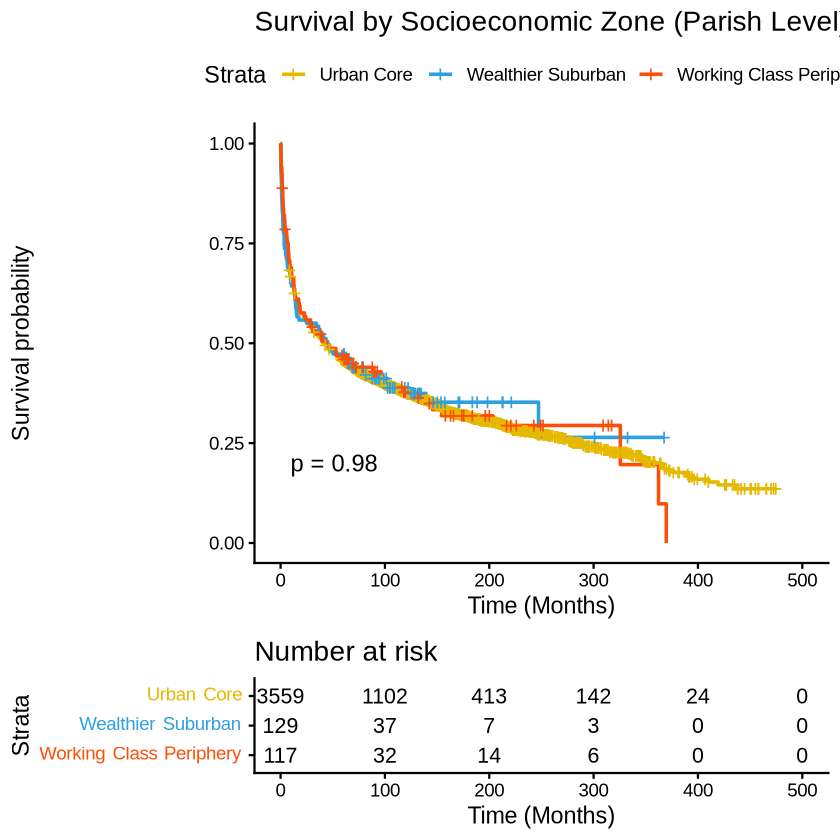

In [5]:
p_geo